### 감성분석 모델링
- LSTM 모델링 및 테스트

- 사용 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
from keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

2024-12-30 17:32:21.452976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-30 17:32:22.374381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/pepsi/venv/project_env/lib/python3.8/site-packages/mxnet/optimizer/optimizer.py:163: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  warnings.warn('WARNING: New optimizer %s.%s is overriding '


1. 데이터 전처리

In [14]:
train_data = pd.read_csv("./data/train_reviews.csv")
test_data = pd.read_csv("./data/test_reviews.csv")
len(train_data), len(test_data)

(8421, 2106)

In [15]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [16]:
X_train = []

okt = Okt()
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_train.append(stopwords_removed_sentence)

100%|██████████| 8421/8421 [02:08<00:00, 65.33it/s] 


In [17]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 2106/2106 [00:24<00:00, 86.52it/s] 


In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [19]:
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 12487
등장 빈도가 2번 이하인 희귀 단어의 수: 7155
단어 집합에서 희귀 단어의 비율: 57.29959157523825
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.824324789858068


In [20]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5333


In [21]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [23]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [24]:
X_train = np.array(X_train, dtype=object)

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

X_train = X_train.tolist()

In [25]:
X_test = np.array(X_test, dtype=object)

X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

X_test = X_test.tolist()

리뷰의 최대 길이 : 552
리뷰의 평균 길이 : 26.620143027413587


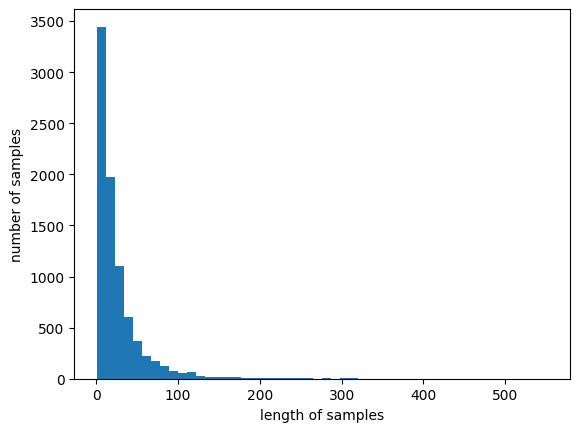

In [26]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [28]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 73.74255065554232


In [29]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

2 LSTM 모델링 및 테스트
- 모델 학습

In [7]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./results/sentiment_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
209/210 [============================>.] - ETA: 0s - loss: 0.1677 - acc: 0.7857
Epoch 1: val_acc improved from -inf to 0.77652, saving model to ./results/sentiment_LSTM.h5
210/210 [==============================] - 16s 64ms/step - loss: 0.1676 - acc: 0.7858 - val_loss: 0.1634 - val_acc: 0.7765
Epoch 2/15
  3/210 [..............................] - ETA: 9s - loss: 0.1639 - acc: 0.7396

/home/pepsi/venv/project_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


209/210 [============================>.] - ETA: 0s - loss: 0.1368 - acc: 0.8129
Epoch 2: val_acc did not improve from 0.77652
210/210 [==============================] - 12s 58ms/step - loss: 0.1367 - acc: 0.8133 - val_loss: 0.1820 - val_acc: 0.7509
Epoch 3/15
210/210 [==============================] - ETA: 0s - loss: 0.1032 - acc: 0.8628
Epoch 3: val_acc did not improve from 0.77652
210/210 [==============================] - 12s 59ms/step - loss: 0.1032 - acc: 0.8628 - val_loss: 0.1979 - val_acc: 0.7574
Epoch 4/15
209/210 [============================>.] - ETA: 0s - loss: 0.0752 - acc: 0.9058
Epoch 4: val_acc did not improve from 0.77652
210/210 [==============================] - 13s 60ms/step - loss: 0.0753 - acc: 0.9054 - val_loss: 0.2083 - val_acc: 0.7378
Epoch 5/15
209/210 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9217
Epoch 5: val_acc did not improve from 0.77652
210/210 [==============================] - 13s 61ms/step - loss: 0.0623 - acc: 0.9218 - val_lo

- 모델 성능 테스트

In [32]:
loaded_model = load_model('results/sentiment_LSTM.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

66/66 [==============================] - 2s 20ms/step - loss: 0.1672 - acc: 0.7733

 테스트 정확도: 0.7733


In [33]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)
  score = float(loaded_model.predict(pad_new))
  if(score >= 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [34]:
sentiment_predict('너무 친절하게 봐주셨는데 다신 가고싶지 않습니다')

1/1 [==============================] - 1s 604ms/step
78.21% 확률로 긍정 리뷰입니다.

